# Detecting Insults in Social Commentary

## 1. Business Understanding

### 1.1 Project description

Analyzing data and detecting if a sentence contains insults, profanity, racial slurs, or any offensive words and building a model to recognize whether these comments containing curse words are directed towards people in the same community/forum and not towards celebrities & public figures.

### 1.2 Project objectives

- Detect whether comments in my dataset contain insults or not
- Analyze and visualize the data
- Differentiate between comments containing profanity targeted toward other users and ones targeted toward celebrities & public figures

## 2. Data Understanding

### 2.1. Importing the data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV


# Download NLTK data
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

# Load the dataset
data = pd.read_csv(r"C:\Users\gaith\OneDrive\Desktop\Insults_Kaggle\train.csv")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gaith\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gaith\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gaith\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 2.2. Data exploration

In [17]:
data.head(25)

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."
5,0,20120620171226Z,"""@SDL OK, but I would hope they'd sign him to ..."
6,0,20120503012628Z,"""Yeah and where are you now?"""
7,1,NaN,"""shut the fuck up. you and the rest of your fa..."
8,1,20120502173553Z,"""Either you are fake or extremely stupid...may..."
9,1,20120620160512Z,"""That you are an idiot who understands neither..."


### 2.2.1 Columns description

- Insults: It can be either 1 or 0 (Some of these comments are not accurately marked. eg: 44)
    0: No insult detected in the comment
    1: Insult detected in the comment
- Date: The date the comment was made --> iN THE FORMAT "YYYYMMDDhhmmssZ"
- Comment: The sentence itself which may or may not contain insults

## 3. Data preparation and pre-processing

### 3.1. Data cleaning

In [18]:
def clean_text(text):
    # Replace certain characters with spaces, excluding "..."
    text = re.sub(r'[^A-Za-z\s,!?@.]', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove extra spaces between words
    text = ' '.join(text.split())
    return text

# Handling missing data in the "Date" column and cleaning the "Comment" column
data['Comment'] = data['Comment'].apply(clean_text)

# Function for lemmatization
def lemmatize_text(text):
    # Tokenize text
    words = nltk.word_tokenize(text)
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

# Apply lemmatization to the 'Comment' column
data['Lemmatized_Comment'] = data['Comment'].apply(lemmatize_text)

# Define a list of bad words (replace with your actual list)
curse_words = ['fuck', 'fucking', 'fucked', 'fucker', 'shitty', 'shit', 'shite', 'retard', 'retarded', 'bitch', 'nigger' , 'whore', 'bastard',
               'faggot', 'douche', 'fag', 'scum', 'idiot', 'stupid', 'negro' , 'dumbass', 'douchebag', 'hoe', 'asshole', 'cunt', 'dickhead', 'cunt',
               'biatch', 'coon', 'motherfucker', 'motherfucking', 'piece of shit', 'scumbag', 'shitbag', 'pieceofshit']

# Function to extract bad words from lemmatized comment
def extract_curse_words(comment):
    return [word for word in comment if word in curse_words]

# Create a new column with the list of bad words in each comment
data['Curse_Words'] = data['Lemmatized_Comment'].apply(extract_curse_words)

#pd.set_option('max_colwidth', None)
data.head(25)

,Insult,Date,Comment,Lemmatized_Comment,Curse_Words
0,1,20120618192155Z,you fuck your dad.,"[you, fuck, your, dad, .]",[fuck]
1,0,20120528192215Z,i really don t understand your point. xa it se...,"[i, really, don, t, understand, your, point, ....",[]
2,0,NaN,a xc xa majority of canadians can and has been...,"[a, xc, xa, majority, of, canadian, can, and, ...",[]
3,0,NaN,listen if you dont wanna get married to a man ...,"[listen, if, you, dont, wan, na, get, married,...",[]
4,0,20120619094753Z,c xe c b u ea n xu u ed ng u u b u eddng bi u ...,"[c, xe, c, b, u, ea, n, xu, u, ed, ng, u, u, b...",[]
5,0,20120620171226Z,"@sdl ok, but i would hope they d sign him to a...","[@, sdl, ok, ,, but, i, would, hope, they, d, ...",[]
6,0,20120503012628Z,yeah and where are you now?,"[yeah, and, where, are, you, now, ?]",[]
7,1,NaN,shut the fuck up. you and the rest of your fag...,"[shut, the, fuck, up, ., you, and, the, rest, ...","[fuck, faggot]"
8,1,20120502173553Z,either you are fake or extremely stupid...mayb...,"[either, you, are, fake, or, extremely, stupid...",[stupid]
9,1,20120620160512Z,that you are an idiot who understands neither ...,"[that, you, are, an, idiot, who, understands, ...",[idiot]


### 3.2. Data visualization

In [19]:
# Initialize a dictionary to store curse words and their frequencies
curse_word_frequencies = Counter()

# Iterate through each row and update the curse_word_counts
for index, row in data.iterrows():
    curse_word_frequencies.update(row['Curse_Words'])

# Print the results in descending order of frequency
for word, count in curse_word_frequencies.most_common():
    print(f'{word}: {count}')

fuck: 257
idiot: 179
fucking: 171
stupid: 155
shit: 152
bitch: 129
whore: 32
retard: 30
fucked: 28
retarded: 26
faggot: 22
asshole: 22
fucker: 19
bastard: 13
scum: 13
cunt: 12
fag: 11
dumbass: 9
negro: 8
shitty: 8
douche: 8
motherfucker: 7
scumbag: 7
hoe: 7
nigger: 6
dickhead: 5
motherfucking: 3
coon: 2
pieceofshit: 1
shite: 1
biatch: 1
douchebag: 1


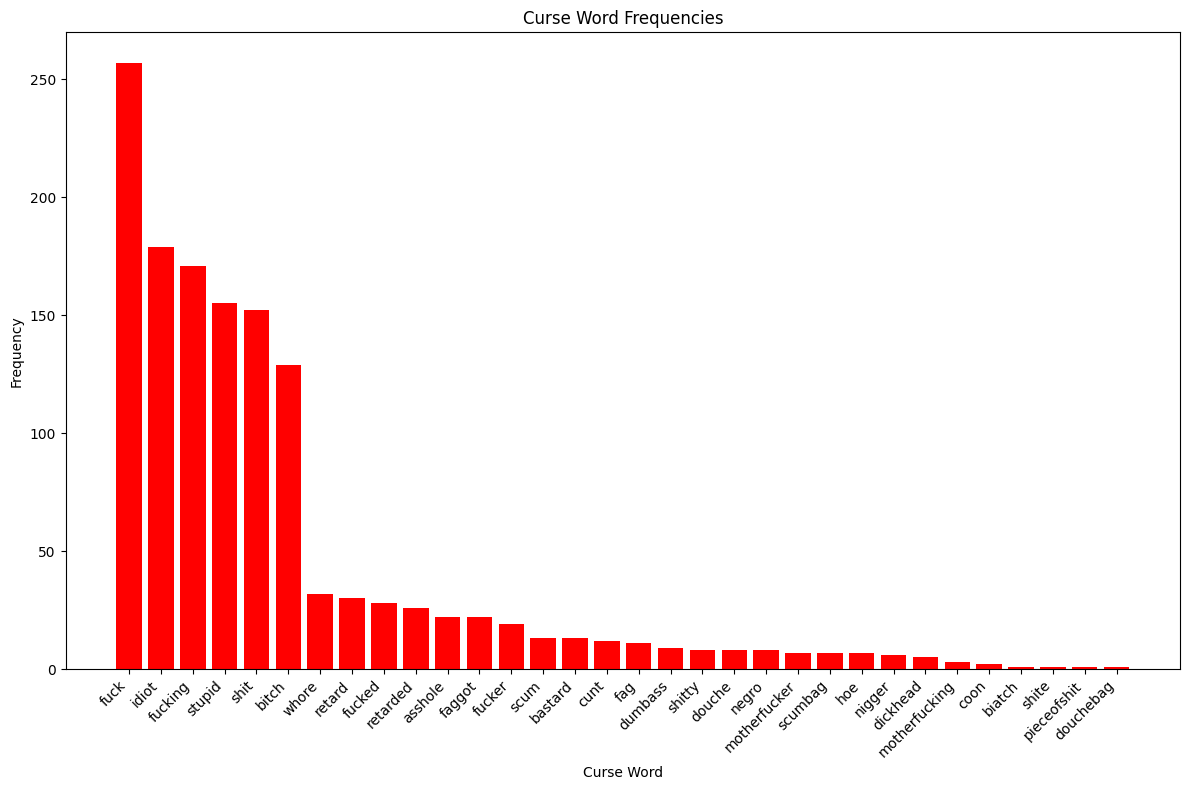

In [20]:
# Convert dictionary to DataFrame for easier plotting
df_curse_word_frequencies = pd.DataFrame(list(curse_word_frequencies.items()), columns=['Curse Word', 'Frequency'])

# Sort the DataFrame by frequency in descending order
df_curse_word_frequencies = df_curse_word_frequencies.sort_values(by='Frequency', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(df_curse_word_frequencies['Curse Word'], df_curse_word_frequencies['Frequency'], color='red')
plt.xlabel('Curse Word')
plt.ylabel('Frequency')
plt.title('Curse Word Frequencies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

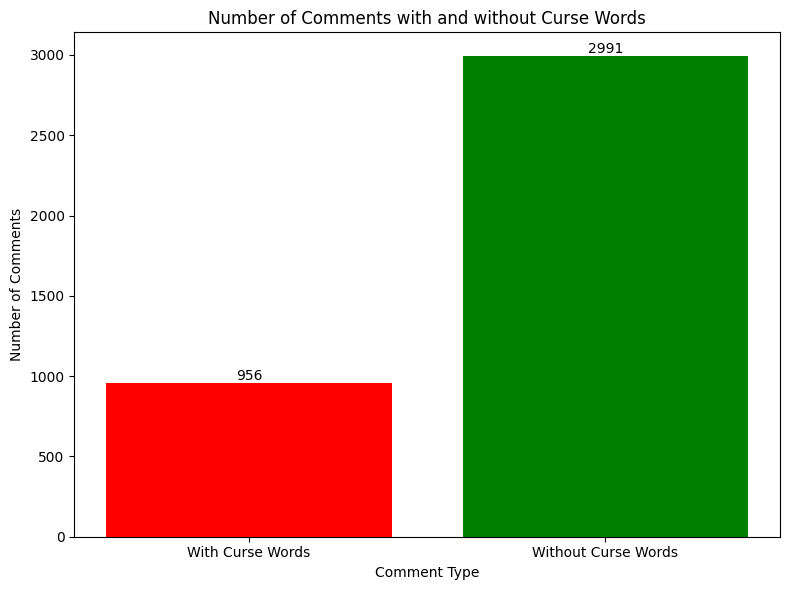

In [21]:
# Count the number of comments with and without curse words
comments_with_curse_words = data[data['Curse_Words'].apply(len) > 0].shape[0]
comments_without_curse_words = data[data['Curse_Words'].apply(len) == 0].shape[0]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(['With Curse Words', 'Without Curse Words'], [comments_with_curse_words, comments_without_curse_words], color=['red', 'green'])
plt.xlabel('Comment Type')
plt.ylabel('Number of Comments')
plt.title('Number of Comments with and without Curse Words')
plt.tight_layout()

# Display exact numbers on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')

plt.show()


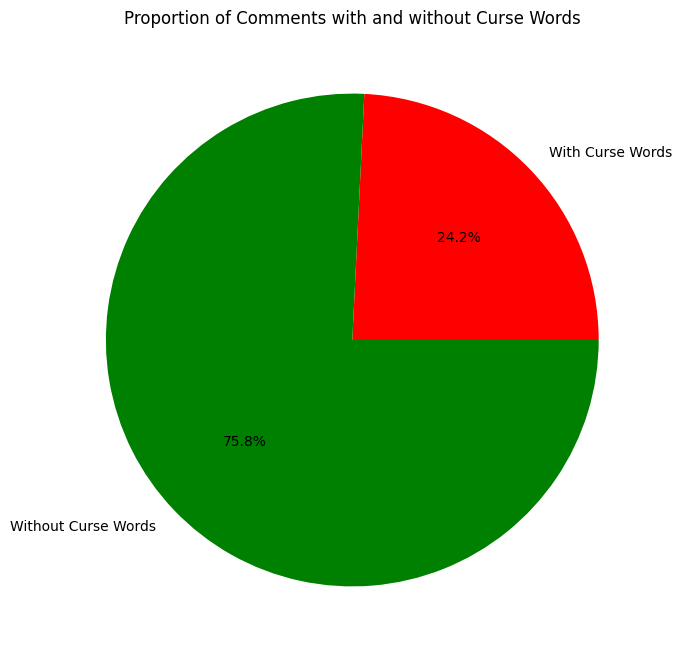

In [22]:
# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie([comments_with_curse_words, comments_without_curse_words], labels=['With Curse Words', 'Without Curse Words'], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Proportion of Comments with and without Curse Words')
plt.show()


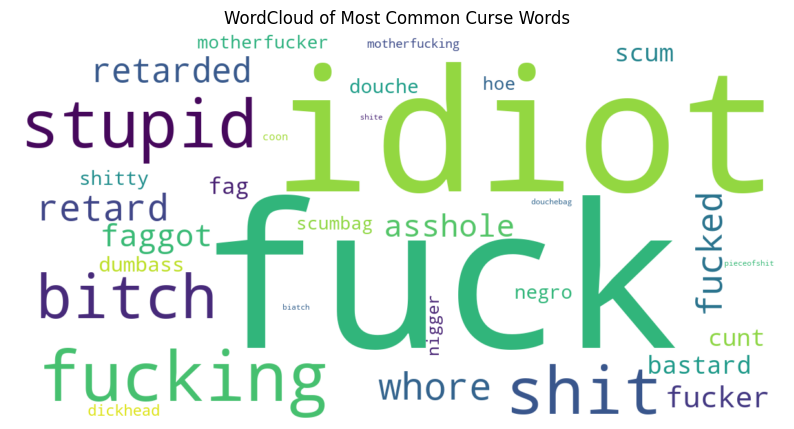

In [23]:
# Combine all curse words into a single list
all_curse_words = [word for words in data['Curse_Words'] for word in words]

# Create a WordCloud object
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(' '.join(all_curse_words))

# Plot the WordCloud
plt.figure(figsize=(10, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Most Common Curse Words')
plt.show()


In [24]:
##KEEP IN MIND THIS MAY NOT BE ACCURATE##

# Apply sentiment analysis to each comment
data['Sentiment_Polarity'] = data['Comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
data['Sentiment_Subjectivity'] = data['Comment'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Display the first few rows of the modified dataset
data.head(25)

,Insult,Date,Comment,Lemmatized_Comment,Curse_Words,Sentiment_Polarity,Sentiment_Subjectivity
0,1,20120618192155Z,you fuck your dad.,"[you, fuck, your, dad, .]",[fuck],-0.400000,0.600000
1,0,20120528192215Z,i really don t understand your point. xa it se...,"[i, really, don, t, understand, your, point, ....",[],0.200000,0.200000
2,0,NaN,a xc xa majority of canadians can and has been...,"[a, xc, xa, majority, of, canadian, can, and, ...",[],0.170000,0.890000
3,0,NaN,listen if you dont wanna get married to a man ...,"[listen, if, you, dont, wan, na, get, married,...",[],0.370000,0.516667
4,0,20120619094753Z,c xe c b u ea n xu u ed ng u u b u eddng bi u ...,"[c, xe, c, b, u, ea, n, xu, u, ed, ng, u, u, b...",[],0.000000,0.000000
5,0,20120620171226Z,"@sdl ok, but i would hope they d sign him to a...","[@, sdl, ok, ,, but, i, would, hope, they, d, ...",[],0.200000,0.233333
6,0,20120503012628Z,yeah and where are you now?,"[yeah, and, where, are, you, now, ?]",[],0.000000,0.000000
7,1,NaN,shut the fuck up. you and the rest of your fag...,"[shut, the, fuck, up, ., you, and, the, rest, ...","[fuck, faggot]",-0.400000,0.600000
8,1,20120502173553Z,either you are fake or extremely stupid...mayb...,"[either, you, are, fake, or, extremely, stupid...",[stupid],-0.312500,1.000000
9,1,20120620160512Z,that you are an idiot who understands neither ...,"[that, you, are, an, idiot, who, understands, ...",[idiot],-0.800000,0.800000


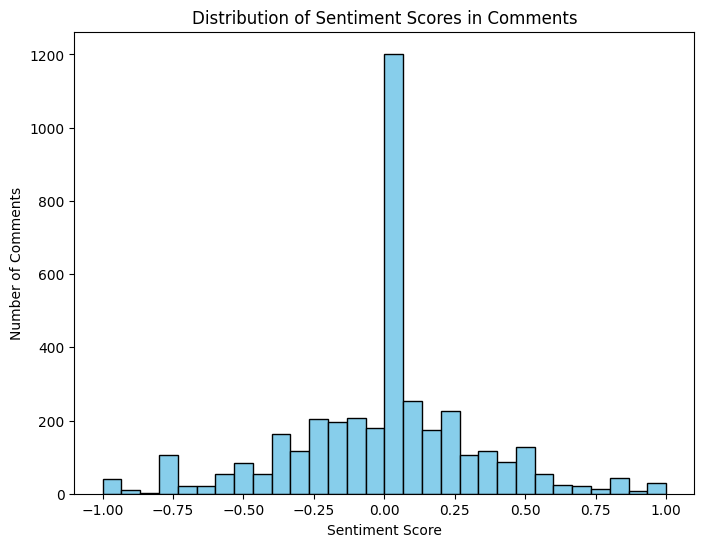

In [25]:
##KEEP IN MIND THIS MAY NOT BE ACCURATE##


# Apply sentiment analysis to each comment
data['Sentiment'] = data['Comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Plot a histogram of sentiment scores
plt.figure(figsize=(8, 6))
plt.hist(data['Sentiment'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Comments')
plt.title('Distribution of Sentiment Scores in Comments')
plt.show()


## 4. Modeling

### 4.1 - Logistic Regression

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Comment'], data['Insult'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Train the model
logreg_model.fit(X_train_tfidf, y_train)

# Make predictions on the testing set
y_pred = logreg_model.predict(X_test_tfidf)

### 4.2 - SVC

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Comment'], data['Insult'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Support Vector Classifier (SVC)
svc_model = SVC(random_state=42)

# Train the model
svc_model.fit(X_train_tfidf, y_train)

# Make predictions on the testing set
y_pred = svc_model.predict(X_test_tfidf)

### 4.3 - Decision Tree Classifier

In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Comment'], data['Insult'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train_tfidf, y_train)

# Make predictions on the testing set
y_pred = dt_model.predict(X_test_tfidf)

### 4.4 - K-Neighbors Classifier

In [29]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Comment'], data['Insult'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train_tfidf, y_train)

# Make predictions on the testing set
y_pred = knn_model.predict(X_test_tfidf)

### 4.5 - Random Forest Classifier

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Comment'], data['Insult'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test_tfidf)

### 4.5.1 - Random Forest Classifier : Hyperparametric tuning

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

# Fit the model to the data
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Use the best parameters to train the final model
final_rf_model = RandomForestClassifier(random_state=42, **best_params)
final_rf_model.fit(X_train_tfidf, y_train)

# Make predictions on the testing set
y_pred = final_rf_model.predict(X_test_tfidf)

## 5. Evaluation

### 5.1 - Logistic Regression

In [11]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.82

Confusion Matrix:
[[532  43]
 [102 113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       575
           1       0.72      0.53      0.61       215

    accuracy                           0.82       790
   macro avg       0.78      0.73      0.74       790
weighted avg       0.81      0.82      0.81       790



### 5.2 - SVG

In [12]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.82

Confusion Matrix:
[[532  43]
 [102 113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       575
           1       0.72      0.53      0.61       215

    accuracy                           0.82       790
   macro avg       0.78      0.73      0.74       790
weighted avg       0.81      0.82      0.81       790



### 5.3 - Decision Tree Classifier

In [13]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.82

Confusion Matrix:
[[532  43]
 [102 113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       575
           1       0.72      0.53      0.61       215

    accuracy                           0.82       790
   macro avg       0.78      0.73      0.74       790
weighted avg       0.81      0.82      0.81       790



### 5.4 - K-Neighbors Classifier

In [14]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.82

Confusion Matrix:
[[532  43]
 [102 113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       575
           1       0.72      0.53      0.61       215

    accuracy                           0.82       790
   macro avg       0.78      0.73      0.74       790
weighted avg       0.81      0.82      0.81       790



### 5.5 - Random Forest Classifier

In [15]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.82

Confusion Matrix:
[[532  43]
 [102 113]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       575
           1       0.72      0.53      0.61       215

    accuracy                           0.82       790
   macro avg       0.78      0.73      0.74       790
weighted avg       0.81      0.82      0.81       790



### 5.5.1 - Random Forest Classifier : Hyperparametric tuning

In [ ]:
# Evaluate the final model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display evaluation metrics
print(f"Best Parameters: {best_params}")
print(f"Final Model Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

## 6. Insights, Conclusions and Business recommendations

In conclusion, The "Random Forest Classifier" is the more suitable model option due to its balanced performance and higher accuracy. Althought both the "Logistic Regression" and the "SVC" models are suitable alternatives with competetively close accuracy.

Businesses can implement a comment/forum moderation system using Random Forest Classifier to moderate and filter out potentially offensive content.